In [1]:

import numpy as np
import matplotlib.pyplot as plt 
import scipy

import sys
sys.path.append("/home/calab912/Documents/fdm-hybrid-scheme/")

import src.fd as fd 
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 
import src.chebyshev as cheby

# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2) / (np.abs(psi_ref[self.inner])**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    

class ChebyshevScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.x      = cheby.grid  (self.totalN - 1, self.Ll, self.Lh) 
        self.D1     = cheby.matrix(self.totalN - 1, self.Ll, self.Lh)
        self.grid   = [self.x]
        self.psi    = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.fields = self.psi 
        Coeff1      = 1j * 1/2  * self.getTimeStep() * self.eta
        self.Dexp   = scipy.linalg.expm(Coeff1 * self.D1) 
        self.counter = 0

    def interpPsi(self, x):
        re, im      =  cheby.coeff(np.real(self.psi)), cheby.coeff(np.imag(self.psi))
        return cheby.interp(x, re, self.x) + 1j * cheby.interp(x, im, self.x)

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1      = 1j * 1/2  * dt * self.eta

        if 1:
            if 1:
                d2psi = cheby.dxn_fft_complex(self.psi, self.Ll, self.Lh, 2)
                d4psi = cheby.dxn_fft_complex(d2psi,    self.Ll, self.Lh, 2)
                d6psi = cheby.dxn_fft_complex(d4psi,    self.Ll, self.Lh, 2)
                d8psi = cheby.dxn_fft_complex(d6psi,    self.Ll, self.Lh, 2)
                self.psi  = self.psi + Coeff1 * d2psi + Coeff1**2/2 * d4psi+ Coeff1**3/6 * d6psi+ Coeff1**4/24 * d8psi
            elif 0: 
                d2psi = cheby.dxn_mat_complex(self.psi, self.D1, 2)
                d4psi = cheby.dxn_mat_complex(d2psi,    self.D1, 2)
                d6psi = cheby.dxn_mat_complex(d4psi,    self.D1, 2)
                d8psi = cheby.dxn_mat_complex(d6psi,    self.D1, 2)
                self.psi  = self.psi + Coeff1 * d2psi + Coeff1**2/2 * d4psi + Coeff1**3/6 * d6psi+ Coeff1**4/24 * d8psi

        else:
            self.psi  = cheby.dxn_mat_complex(self.psi, self.Dexp, 1)

        self.counter += 1 

        self.t += dt

    def getName(self):
        return "chebyshev scheme"
    
    def getDx(self): 
        return self.x[1] - self.x[0]
    

class ChebyshevSubregionScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
  
        if "printGrid" in config: 
            self.print_grid = config["printGrid"]
        else:
            self.print_grid = False

        self.patchSize = config["patchSize"]

        # Create sub patches
        self.NPatch     = int(self.innerN/self.patchSize)
        self.innerWidth = self.boxWidth / self.NPatch 
        self.patchInner = cheby.grid(self.totalN - 1, 0, self.innerWidth)
        self.ghostWidth = self.patchInner[self.ghostBoundarySize]
        self.outerWidth = self.boxWidth / self.NPatch 
        self.patchInner = cheby.grid(self.totalN - 1, self.Ll, self.Lh) 
        self.patchWidth = self.dx * (self.patchSize - 1)


        ghostPoints     = self.ghostBoundarySize
        patchSize       = self.patchSize
        domainPoints    = self.innerN
        NPatch          = int(domainPoints/patchSize)
        innerWidth      = self.boxWidth / NPatch 
        patchInner      = cheby.grid(patchSize+2*ghostPoints - 1, 0, innerWidth)
        tempWidth       = patchInner[-self.ghostBoundarySize - 1] - patchInner[self.ghostBoundarySize]
        rescaling       = innerWidth/tempWidth
        outerWidth      = innerWidth * rescaling
        ghostWidth      = (outerWidth - innerWidth) / 2

        self.NPatch     = NPatch 
        self.patchWidth = innerWidth

        if self.print_grid: 
            print(f"Patch number = {self.NPatch}, patch size = {self.patchSize} and patch width = {self.patchWidth} and patch number times patch width = {self.patchWidth * self.NPatch}")

        for i in range(NPatch): 
            patchOuter = cheby.grid(patchSize+2*self.ghostBoundarySize- 1, -ghostWidth + i * innerWidth, (i+1) * innerWidth + ghostWidth)


        self.patches = []
    
        patchConfig                = dict(config)
        patchConfig["resolution"]  = self.patchSize
        patchConfig["useBC"]       = False 

        for i in range(self.NPatch):
            s        = ChebyshevScheme(patchConfig, generateIC)

            totalN    = patchSize + 2 * self.ghostBoundarySize
            L0        =  i    * innerWidth
            L1        = (i+1) * innerWidth
            Ll        = - ghostWidth + L0
            Lh        = + ghostWidth + L1 
            s.x       = cheby.grid  (totalN - 1, Ll, Lh)
            s.D1      = cheby.matrix(totalN - 1, Ll, Lh)
            s.Ll      = Ll 
            s.L0      = L0 
            s.Lh      = Lh 
            s.L1      = L1 
            s.grid    = [s.x]
            s.dx      = self.dx 
            s.psi     = self.generateIC(*s.grid, s.dx, s.t, s.m, s.hbar)
            s.fields  = self.psi 
            Coeff1    = 1j * 1/2  * s.getTimeStep() * s.eta
            s.Dexp    = scipy.linalg.expm(Coeff1 * s.D1) 
            s.left    = np.ix_(range(self.ghostBoundarySize))
            s.right   = np.ix_(range(len(patchOuter) - self.ghostBoundarySize, len(patchOuter)))

            if self.print_grid: 
                print(f"Grid points {len(s.x)} L0 {L0} L1 {L1} Ll {Ll} Lh {Lh} x {s.x} left {s.left} right {s.right}")

            self.patches.append(s)


        #Set neighbour patches in 1D case
        if self.NPatch == 1:
            self.patches[i].lpatch = None
            self.patches[i].rpatch = None 
        else:
            for i in range(self.NPatch):
                if i == 0: 
                    self.patches[i].lpatch = None
                    self.patches[i].rpatch = self.patches[i+1]
                elif i == self.NPatch - 1: 
                    self.patches[i].rpatch = None 
                    self.patches[i].lpatch = self.patches[i-1]
                else: 
                    self.patches[i].lpatch = self.patches[i-1]
                    self.patches[i].rpatch = self.patches[i+1]


        self.debugWavefunction  = False 
        self.debugShiftfunction = False 


    def step(self, dt):
        
        if self.print_grid:
            plt.title(f"Patches before exchange")
            
        #Fill ghost zones of patches and set boundary conditions
        for i in range(self.NPatch):
            s = self.patches[i]

            if self.print_grid:
                plt.plot(self.patches[i].x, np.abs(self.patches[i].psi), label=f"{i} before")

            if s.lpatch == None:
                s.psi[s.left ] = self.generateIC   (s.x[s.left ], self.dx, self.t, self.m, self.hbar)
            else: 
                s.psi[s.left ] = s.lpatch.interpPsi(s.x[s.left ])

            if s.rpatch == None: 
                s.psi[s.right] = self.generateIC   (s.x[s.right], self.dx, self.t, self.m, self.hbar)
            else: 
                s.psi[s.right] = s.rpatch.interpPsi(s.x[s.right])

            if self.print_grid:
                plt.plot(self.patches[i].x, np.abs(self.patches[i].psi), label=f"{i} after")

        if self.print_grid:
            plt.legend()
            plt.show() 


        #Advance patches 
        for i in range(self.NPatch):
            self.patches[i].debugWavefunction  = self.debugWavefunction 
            self.patches[i].debugShiftfunction = self.debugShiftfunction
            self.patches[i].step(dt)
            if self.print_grid:
                plt.title(f"Patch {i}")
                plt.plot(np.abs(self.patches[i].psi))
                plt.show()

            #print(f"t = {self.t} i = {i} RMS error = {self.patches[i].computeRMSError()}")

        self.t += dt



    def getName(self):
        return "subregion scheme"

    def computeRelError(self):
        errors = [self.patches[i].computeRelError() for i in range(self.NPatch)]
        return np.max(errors)

    def computeRMSError(self):
        errors = np.array([self.patches[i].computeRMSError() for i in range(self.NPatch)])
        return np.sqrt(np.mean(errors**2))
    
    def getPsi(self): 
        return np.concatenate([self.patches[i].psi[self.patches[i].inner] for i in range(self.NPatch)])

    def getGrid(self): 
        return [np.concatenate([self.patches[i].x[self.patches[i].inner] for i in range(self.NPatch)])]

    
    def getDensity(self): 
        return np.abs(self.getPsi())**2
    
    def getPhase(self): 
        psi = self.getPsi()
        return np.arctan2(np.imag(psi), np.real(psi))
    
    def getPotential(self):
        return np.zeros(self.innerN)


Finished in 2731 time steps


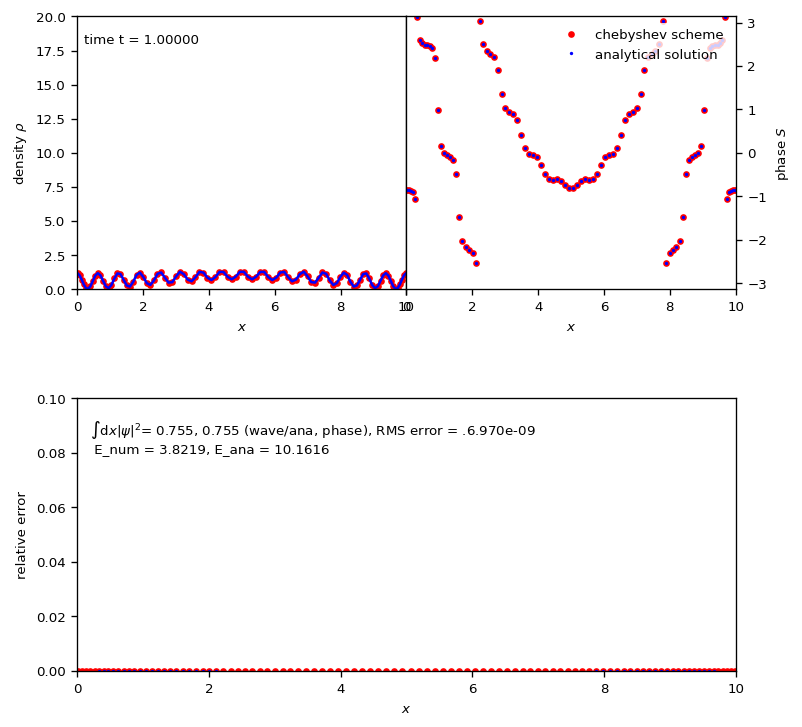

In [14]:
c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 128
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [-0, 10]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["dt"]                         = 0.06*(10/128)**2 
scheme = ChebyshevScheme(c, periodic1DGaussian) 
scheme.run()
animation.drawFrame(scheme)

Finished in 5377 time steps


(6.5257923587383815e-09, 7.274444396075685e-10)

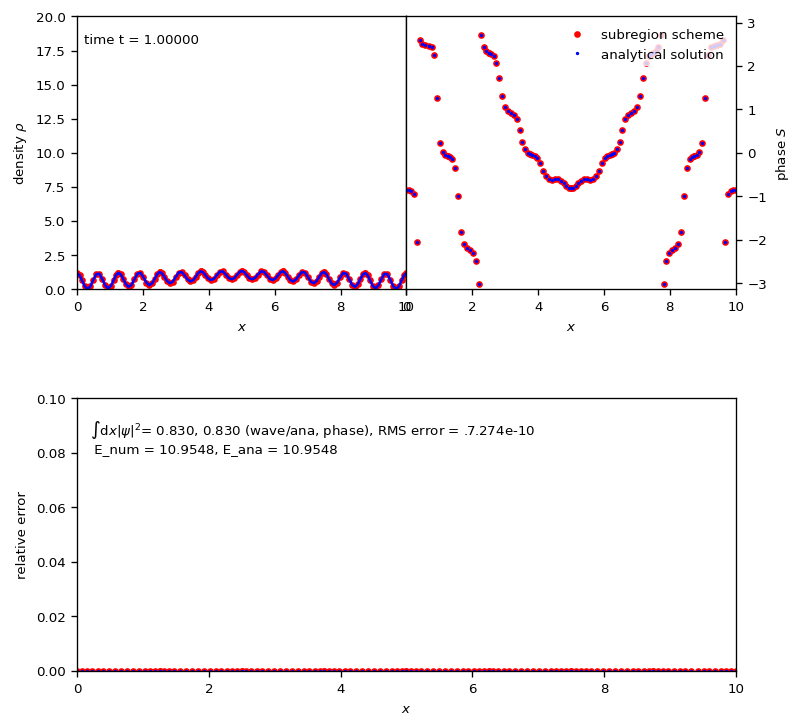

In [15]:
c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 128
c["patchSize"]                  = 16
c["boundarySize"]               = 8
c["useBC"]                      = False
c["domainSize"]                 = [0, 10]
c["xlim"]                       = [0, 10]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.03
c["printGrid"]                  = False
scheme = ChebyshevSubregionScheme(c, periodic1DGaussian) 
scheme.run()
animation.drawFrame(scheme)
scheme.computeRelError(), scheme.computeRMSError()

Finished in 92161 time steps


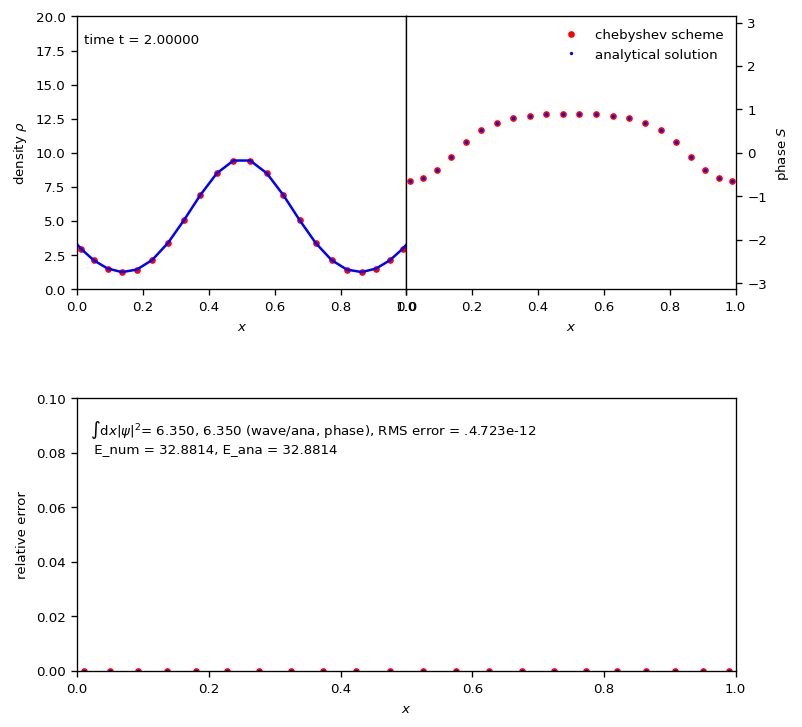

In [4]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = x[-1] - x[0]
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 2.0
c["resolution"]                 = 32
c["boundarySize"]               = 8
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["dt"]                         = 0.05*(1/48)**2 
scheme = ChebyshevScheme(c, periodic1DGaussian) 
scheme.run()
animation.drawFrame(scheme)